In [2]:
# Librerías estándar y manipulación de archivos
import os
import joblib
import json
import pickle

# Manipulación de datos y operaciones básicas
import numpy as np
import pandas as pd

# Visualización de datos
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.animation import FuncAnimation

# Reducción de dimensionalidad
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Preprocesamiento de datos
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Técnicas de balanceo de clases
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.pipeline import Pipeline

# Configuraciones adicionales
import warnings

# Se ignoran los warnings en el notebook
warnings.filterwarnings('ignore')

# **3- Carga de datos tras EDA - Hipótesis P6E: (64, ∞)**

In [3]:
# Carga de los datos obtenido tras el EDA
med_app_EDA = pd.read_csv('med_app_FE.csv')
med_app_FE = med_app_EDA.copy()

# Filtrar los datos donde Age sea mayor que 64 
med_app_FE = med_app_FE[(med_app_FE['Age'] > 64)]

# Al cargar los datos se pierden cierto tipos de datos establecido en el EDA, a continuación se corrigen
med_app_FE['ScheduledDay'] = pd.to_datetime(med_app_FE['ScheduledDay']).dt.tz_localize(None)
med_app_FE['AppointmentDay'] = pd.to_datetime(med_app_FE['AppointmentDay']).dt.tz_localize(None)
med_app_FE['Gender'] = med_app_FE['Gender'].astype('int32')
med_app_FE['App_DayOfWeek'] = med_app_FE['App_DayOfWeek'].astype('int32')
med_app_FE['Neighbourhood'] = med_app_FE['Neighbourhood'].astype('int32')

In [4]:
# Número de pacientes únicos
NUMBER_PATIENTS = med_app_FE['PatientId'].nunique()
print('Variable NUMBER_PATIENTS: ', NUMBER_PATIENTS)

# Distribución de NoShow igual a 1
class_counts = med_app_FE['NoShow'].value_counts()
NUMBER_NO_SHOWS = class_counts[1]
print('Variable NUMBER_NO_SHOWS: ', NUMBER_NO_SHOWS)

# Numero de filas
NUMBER_SAMPLES = med_app_FE.shape[0]
print('Variable NUMBER_SAMPLES: ', NUMBER_SAMPLES)

Variable NUMBER_PATIENTS:  8358
Variable NUMBER_NO_SHOWS:  2231
Variable NUMBER_SAMPLES:  14392


In [5]:
med_app_FE.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14392 entries, 19 to 110483
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   PatientId                14392 non-null  int64         
 1   AppointmentID            14392 non-null  int64         
 2   Gender                   14392 non-null  int32         
 3   ScheduledDay             14392 non-null  datetime64[ns]
 4   AppointmentDay           14392 non-null  datetime64[ns]
 5   App_DayOfWeek            14392 non-null  int32         
 6   Time_SchDay_to_AppDay    14392 non-null  int64         
 7   Days_since_last_App      14392 non-null  int64         
 8   Age                      14392 non-null  int64         
 9   Neighbourhood            14392 non-null  int32         
 10  Neigh_Cluster            14392 non-null  int64         
 11  Health_Centre            14392 non-null  int64         
 12  Temperature              14392 non-

## 3.1 Visualización de la **matriz de correlación** entre todas las variables, incluída la Target.

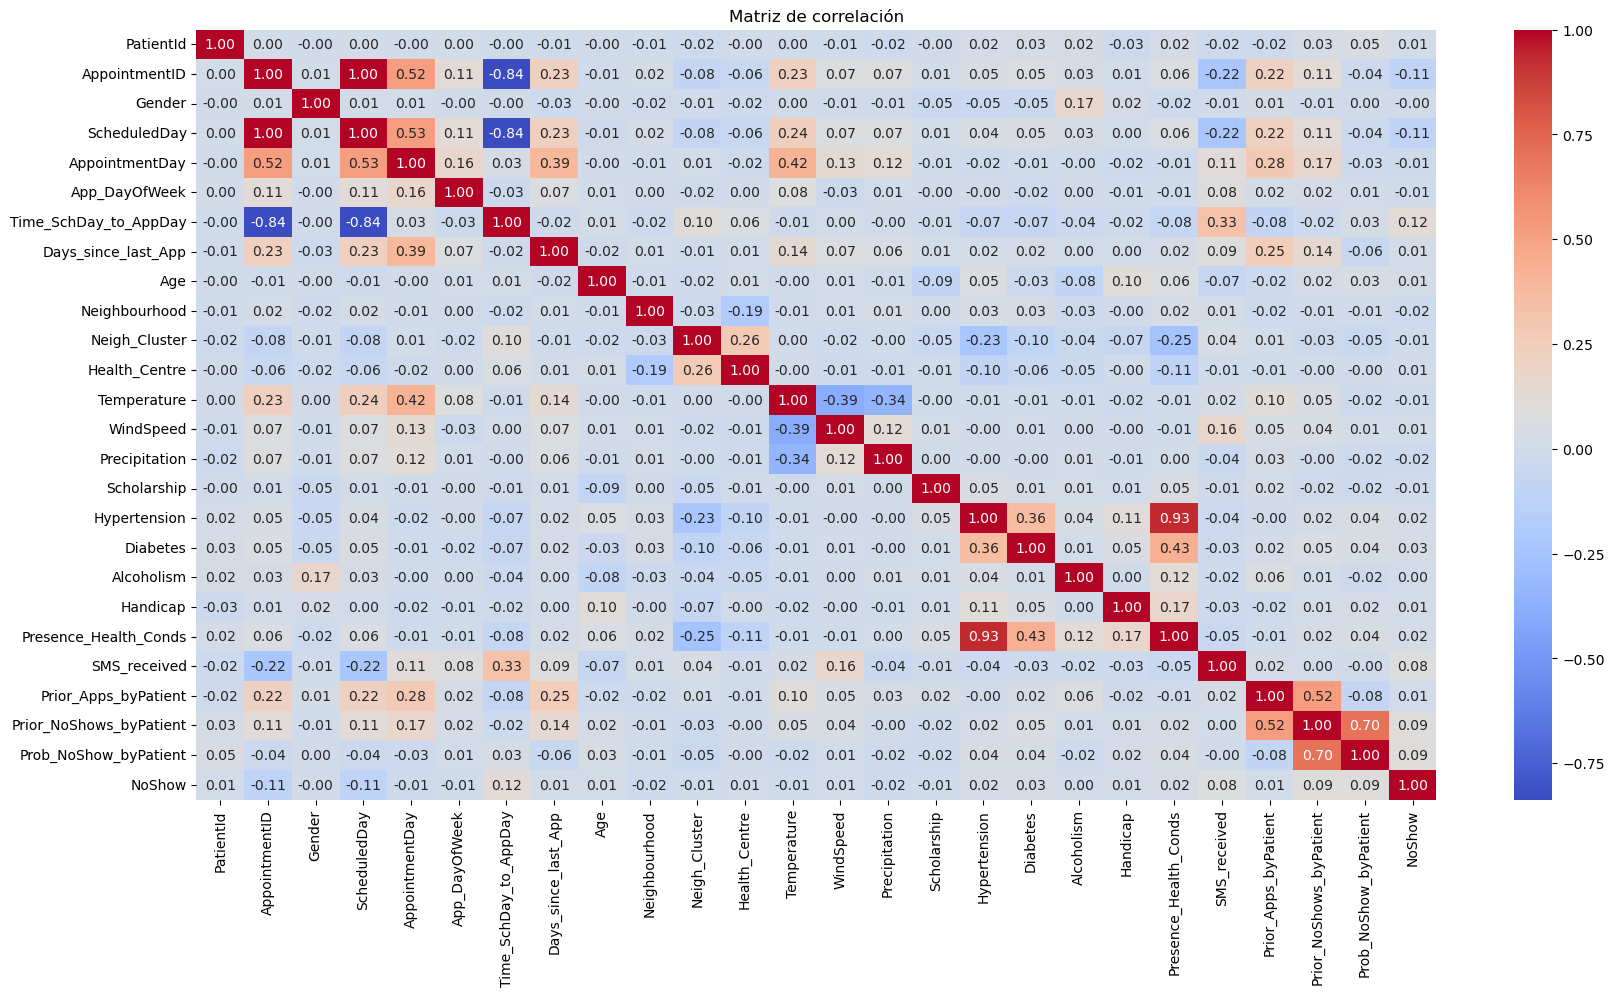

In [6]:
# Cálculo de la matriz de correlación
correlation = med_app_FE.corr()

# Visualización de la matriz de correlación con un mapa de calor
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

# **4- Conformación de los sets de entrenamiento y prueba**

## 4.1 División del dataset en los conjuntos de entrenamiento y prueba

La estructura del dataset Medical Appointments contiene un fuerte componente temporal, con la información de los pacientes que van asistiendo de forma regular a consulta médica.

Se divide el dataset de forma que el set de prueba corresponda sólo a las últimas citas de pacientes distintos, intentando que todos ellos tengan las citas asignadas al final del periodo temporal que comprende el dataset, manteniendo la misma estratificación de clases que en el dataset original.

In [7]:
NUMBER_Apps_inTest = int(NUMBER_SAMPLES * 0.20)
print(f"Para alcanzar el 20% del muestreo en nuestro set de pruebas\n \
necesitamos {NUMBER_Apps_inTest} citas de pacientes distintos, es decir,\n \
muestras de un {NUMBER_Apps_inTest / NUMBER_PATIENTS:.2%} de los pacientes.")

Para alcanzar el 20% del muestreo en nuestro set de pruebas
 necesitamos 2878 citas de pacientes distintos, es decir,
 muestras de un 34.43% de los pacientes.


In [8]:
# Creación del sub-dataset que contiene sólo la última cita de cada paciente 
last_app_byPatient = med_app_FE.groupby('PatientId').last()

# Ordenación por 'AppointmentDay'
last_app_byPatient = last_app_byPatient.sort_values(by = 'AppointmentDay')

# Cálculo del número de citas NoShow = True que se requieren para mantener la estratificación de Clases
NUMBER_NoShows_inTest = int(NUMBER_Apps_inTest * (NUMBER_NO_SHOWS / NUMBER_SAMPLES))
NUMBER_Shows_inTest = int(NUMBER_Apps_inTest - NUMBER_NoShows_inTest)
print(f"Se requieren {NUMBER_NoShows_inTest} pacientes con 'NoShow' = True en el Set de Prueba, y\n \
{NUMBER_Shows_inTest} pacientes con 'NoShow' = False.\n")

# Selección de las últimas 4463 muestras del sub-dataset 'last_app_byPatient' con 'NoShow' = True
test_set_NoShows = last_app_byPatient[last_app_byPatient['NoShow'] == True][-(NUMBER_NoShows_inTest+1):-1]

# Selección de las últimas 17642 muestras del sub-dataset 'last_app_byPatient' con 'NoShow' = False
test_set_Shows = last_app_byPatient[last_app_byPatient['NoShow'] == False][-(NUMBER_Shows_inTest+1):-1]

# Concatenación de ambos sub-dataset en el Set de Pruebas
test_set = pd.concat([test_set_NoShows, test_set_Shows])

# Selección del Set de Pruebas definitivo
test_set = med_app_FE[med_app_FE['AppointmentID'].isin(test_set['AppointmentID'])]
print(f"Creado Set de Prueba con {test_set.shape[0]} citas de \
{test_set['PatientId'].nunique()} pacientes distintos.")

# Selección del Set de Entrenamiento definitivo
train_set = med_app_FE[~med_app_FE['AppointmentID'].isin(test_set['AppointmentID'])]
print(f"Creado Set de Entrenamiento con {train_set.shape[0]} citas de \
{train_set['PatientId'].nunique()} pacientes distintos.")

Se requieren 446 pacientes con 'NoShow' = True en el Set de Prueba, y
 2432 pacientes con 'NoShow' = False.

Creado Set de Prueba con 2878 citas de 2878 pacientes distintos.
Creado Set de Entrenamiento con 11514 citas de 7001 pacientes distintos.


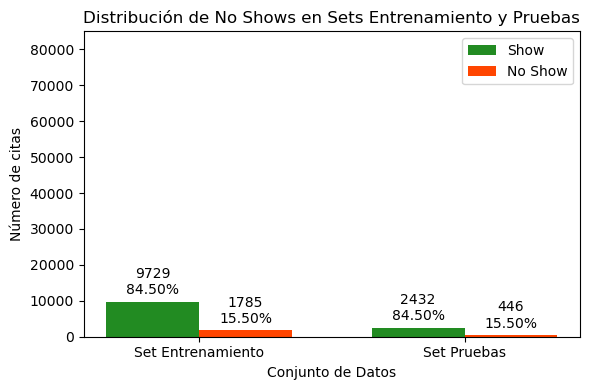

In [9]:
# Creación de la figura
fig,ax = plt.subplots(figsize = (6, 4))

# Configuración posición y de las barras
width = 0.35
offsets = np.linspace(-width/2, width/2, 2)

labels = ['Show', 'No Show']
colors =['forestgreen', 'orangered']

def create_bars(datasets):
    for pos, dataset in enumerate(datasets):
        class_counts = dataset['NoShow'].value_counts()
        rects_list = []
        for i, counts in enumerate(class_counts.values):
            rects_list.append(ax.bar(x = pos + offsets[i],
                                    height = counts,
                                    width = width,
                                    color = colors[i]))
            if pos == 1:  # Solo añadir la leyenda en la primera iteración
                rects_list[-1].set_label(labels[i])
            height = int(rects_list[i].datavalues)
            total_height = dataset.shape[0]
            ax.annotate(f'{height}\n{height/total_height:.2%}',
                        xy = (pos + offsets[i], height),
                        xytext = (0, 25), textcoords = "offset points",
                        ha = 'center', va = 'top')
    return

create_bars([train_set, test_set])

# Configuración de ejes y título
ax.set_xlabel('Conjunto de Datos')
ax.set_ylabel('Número de citas')
ax.set_title("Distribución de No Shows en Sets Entrenamiento y Pruebas")
ax.set_xticks([0, 1], ['Set Entrenamiento', 'Set Pruebas'])
ax.legend(loc='upper right')
ax.set_ylim(0, 85000)

plt.tight_layout()
plt.show()

## 4.2 Eliminación de las variables que no aportan información relevante

Se considera que las siguientes variables no contienen información relevante, por los motivos expuestos:

- **'AppointmentID'**: Número diferente asignado a cada cita, en función de la fechas de programación de cita.

  - *La correlación que se observa con la variable Target 'NoShows' (-0.16) es directamente proporcional a la correlación existente entre la diferencia de tiempo entre el 'AppointmentDay' y el 'ScheduledDay' ('Time_SchDay_to_AppDay') con 'NoShows', ya que las primeras citas programadas son las que tienen los números AppointmentID más bajos, y éstas coinciden con las que tienen el 'Time_SchDay_to_AppDay' más alto.*

- **'PatientId'**: Número diferente asignado a cada paciente. Dicho número es aleatorio.

- **ScheduledDay** y **'AppointmentDay**: Día de programación de la cita y de día de asignación de cita, respectivamente.

  - *Con el Feature Engineering ya se ha guardado toda la información relevante que contienen estas fechas*

- **'Neighbourhood'**: Barrio de residencia de cada paciente.

  - *Esta información ya se ha agrupado en la variable 'Neigh_Cluster'.*

- **SMS_received**: Variable que guarda información sobre la recepción o no de SMS recordatorio de asistencia a la cita, para cada cita.

  - *El envío de SMS's recordatorios es importante para disminuir las ausencias, pero no lo podemos usar como variable predictora en el algoritmo de predicción, ya que no se dispondrá dicha información en el momento de programación de la cita.*

In [10]:
# Definición de las variables que no aportan información:
columns_to_drop = ['AppointmentID',
                    'PatientId',
                    'ScheduledDay',
                    'AppointmentDay',
                    'Neighbourhood',
                    'SMS_received']

# En el set de entrenamiento:
train_set.drop(columns = columns_to_drop, inplace = True)
# En el set de pruebas:
test_set.drop(columns = columns_to_drop, inplace = True)

In [11]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11514 entries, 19 to 110483
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   11514 non-null  int32  
 1   App_DayOfWeek            11514 non-null  int32  
 2   Time_SchDay_to_AppDay    11514 non-null  int64  
 3   Days_since_last_App      11514 non-null  int64  
 4   Age                      11514 non-null  int64  
 5   Neigh_Cluster            11514 non-null  int64  
 6   Health_Centre            11514 non-null  int64  
 7   Temperature              11514 non-null  float64
 8   WindSpeed                11514 non-null  float64
 9   Precipitation            11514 non-null  float64
 10  Scholarship              11514 non-null  int64  
 11  Hypertension             11514 non-null  int64  
 12  Diabetes                 11514 non-null  int64  
 13  Alcoholism               11514 non-null  int64  
 14  Handicap                 

In [12]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2878 entries, 28 to 110480
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   2878 non-null   int32  
 1   App_DayOfWeek            2878 non-null   int32  
 2   Time_SchDay_to_AppDay    2878 non-null   int64  
 3   Days_since_last_App      2878 non-null   int64  
 4   Age                      2878 non-null   int64  
 5   Neigh_Cluster            2878 non-null   int64  
 6   Health_Centre            2878 non-null   int64  
 7   Temperature              2878 non-null   float64
 8   WindSpeed                2878 non-null   float64
 9   Precipitation            2878 non-null   float64
 10  Scholarship              2878 non-null   int64  
 11  Hypertension             2878 non-null   int64  
 12  Diabetes                 2878 non-null   int64  
 13  Alcoholism               2878 non-null   int64  
 14  Handicap                 2

## 4.3 Se guarda la información de los Sets de Entrenamiento y Prueba, antes de separar etiquetas, estandarizar y balancear con SMOTE+ENN

In [13]:
# Exportar el DataFrame a archivos csv
train_set.to_csv('train_set_P6E-OLDERADULTS.csv', index=False)
test_set.to_csv('test_set_P6E-OLDERADULTS.csv', index=False)

# Exportar el DataFrame a archivo Excel
train_set.to_excel('train_set_P6E-OLDERADULTS.xlsx', index=False)
test_set.to_excel('test_set_P6E-OLDERADULTS.xlsx', index=False)

## 4.4 División de las variables predictoras de la variable target (etiquetas)

In [14]:
# Se divide el conjunto de entrenamiento en características y etiquetas
X_train_set = train_set.drop('NoShow', axis=1)
y_train_set = train_set['NoShow']
X_test_set = test_set.drop('NoShow', axis=1)
y_test_set = test_set['NoShow']

# **5- Últimas transformaciones de los datasets antes del entrenamiento**

## 5.1 Estandarización de las bases de datos

In [15]:
# Guardar los nombres de las columnas
column_names = X_train_set.columns

# Se crea una instancia de StandardScaler
scaler = StandardScaler()

# Se ajusta el escalador a los datos de entrenamiento y se transforman
X_train_scaled = scaler.fit_transform(X_train_set)
# Se transforman los datos de test utilizando el mismo escalador que se ajustó a los datos de entrenamiento
X_test_scaled = scaler.transform(X_test_set)

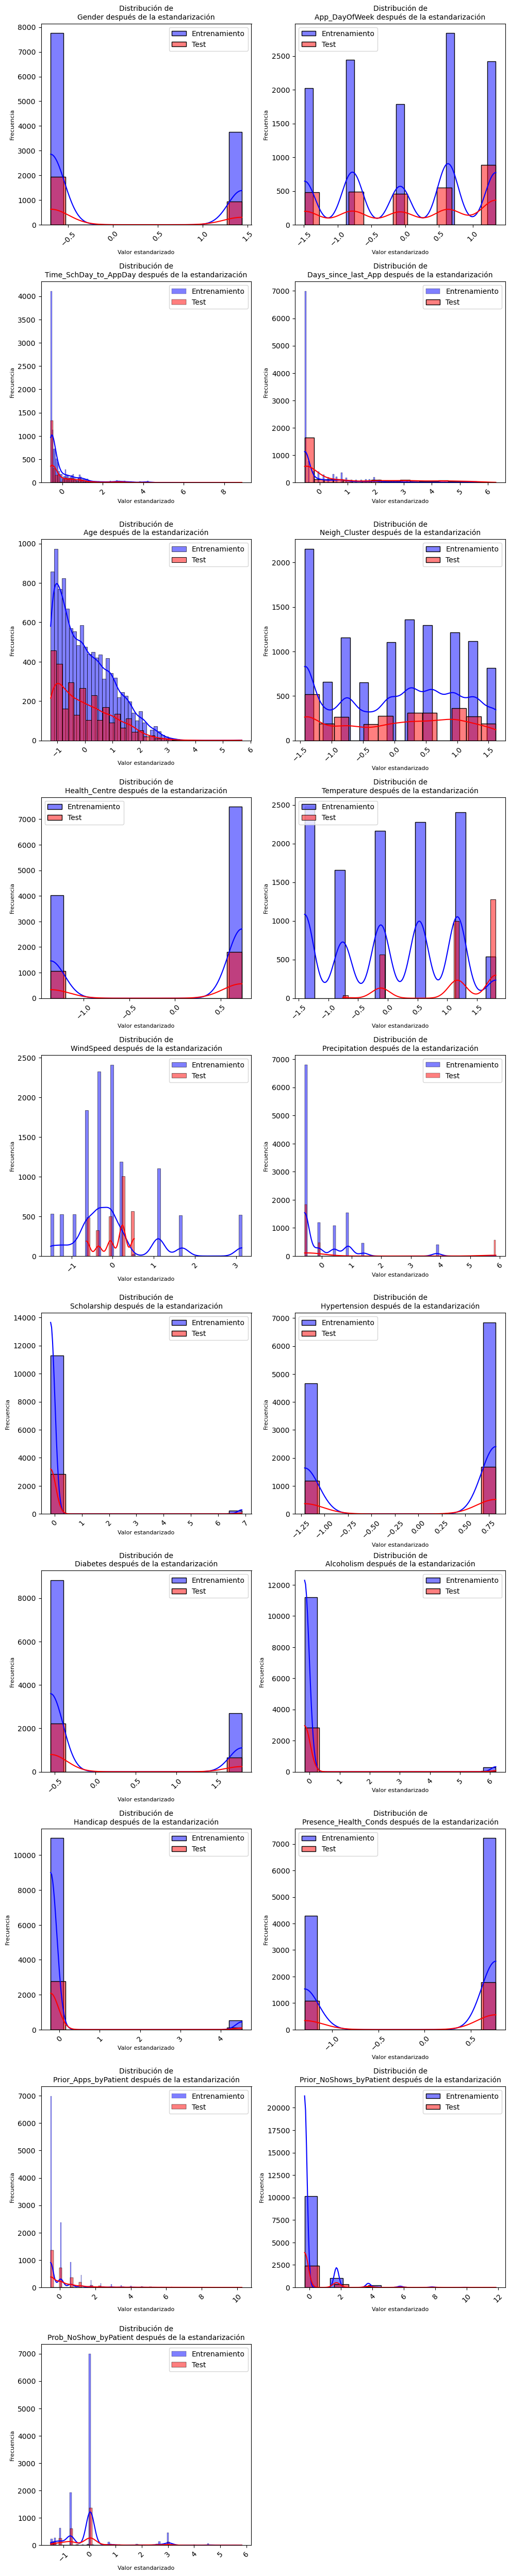

In [16]:
# Convertir los resultados a DataFrame para facilitar la manipulación y visualización, 
# utilizando los nombres de las columnas guardados previamente
X_train_df = pd.DataFrame(X_train_scaled, columns = column_names)
X_test_df = pd.DataFrame(X_test_scaled, columns = column_names)

# Número de características en el DataFrame
num_features = X_train_df.shape[1]

# Número de columnas para los sub-gráficos
num_columns = 2

# Calcular el número de filas basado en el número de características y columnas
num_rows = num_features // num_columns + (num_features % num_columns > 0)


# Crear una figura grande para acomodar todos los sub-gráficos
plt.figure(figsize=(10, 5 * num_rows))

# Crear un histograma para cada característica
for i in range(num_features):
    plt.subplot(num_rows, num_columns, i+1)
    
    # Histograma de los datos de entrenamiento en azul
    sns.histplot(X_train_df.iloc[:, i], kde=True, color='blue', alpha=0.5, label='Entrenamiento')
    
    # Histograma de los datos de test en rojo
    sns.histplot(X_test_df.iloc[:, i], kde=True, color='red', alpha=0.5, label='Test')
    
    # Usar un salto de línea para dividir el título en dos líneas
    plt.title(f'Distribución de\n{column_names[i]} después de la estandarización', fontsize=10)
    
    plt.xlabel('Valor estandarizado', fontsize=8)
    plt.ylabel('Frecuencia', fontsize=8)
    plt.xticks(rotation=45)
    plt.legend()

plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

## 5.2 DATA AUGMENTATION para balancear las clases en el dataset de entrenamiento (**SMOTE** y **EDITED NEAREST NEIGHBOURS**)

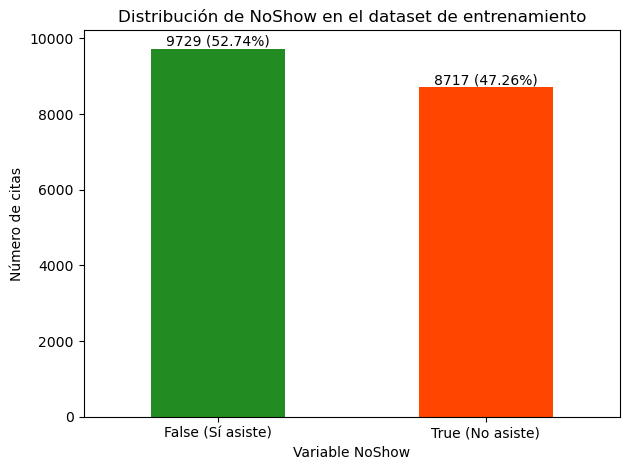

In [17]:
# Se crea una instancia de SMOTE y ENN
smote = SMOTE(sampling_strategy = 'minority',
                random_state = 42)
enn = EditedNearestNeighbours(sampling_strategy = 'not minority',
                                kind_sel = 'all',
                                n_neighbors = 2)

# Se crea una instancia de la clase Pipeline
pipeline = Pipeline([('smote', smote), ('enn', enn)])

# Se aplica el pipeline a los datos
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_scaled, y_train_set)

# Distribución del dataset posterior a la aplicación de SMOTE-ENN
class_counts = y_train_resampled.value_counts()

# Se define el gráfico con los parámetros adicionales solicitados
class_counts.plot(kind='bar', rot=0, color=['forestgreen', 'orangered'])

# Se añaden etiquetas y título al gráfico
plt.xlabel('Variable NoShow')
plt.ylabel('Número de citas')
plt.title('Distribución de NoShow en el dataset de entrenamiento')

# Se añaden los porcentajes en las barras
for i, count in enumerate(class_counts):
    plt.text(i, count, f'{count} ({count / len(X_train_resampled) * 100:.2f}%)', ha='center', va='bottom')
    
# Se establecen las etiquetas en el eje X
plt.xticks([0, 1], ['False (Sí asiste)', 'True (No asiste)'])

# Se muestra el gráfico
plt.tight_layout()
plt.show()

## 5.3 Reducción de dimensionalidad (**PCA**)

In [18]:
# Aplicar PCA para reducir la dimensionalidad mientras se conserva la mayor cantidad de varianza posible
pca = PCA(n_components = 0.95,
            svd_solver = 'full') 

# Ajustar y transformar los datos de entrenamiento
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test_scaled)

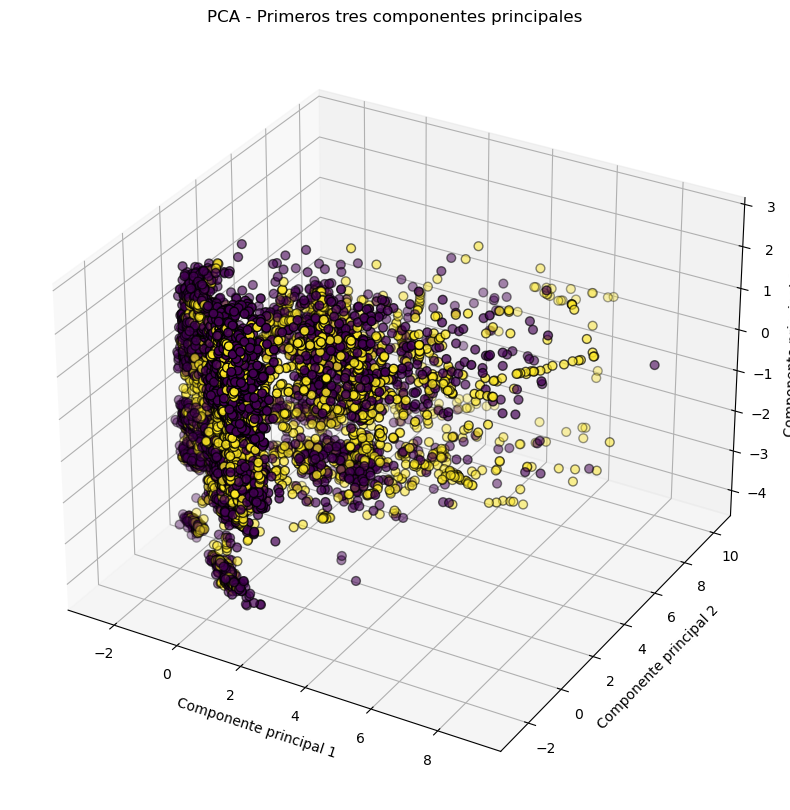

Número de componentes: 16
Varianza explicada por cada componente: [0.12669015 0.12188643 0.09215653 0.07087281 0.06308511 0.06099221
 0.05790873 0.05401497 0.05070297 0.04980247 0.04323388 0.04182213
 0.03892776 0.03638704 0.0341949  0.0325207 ]
Varianza total explicada: 0.9751987928904097


In [19]:
# Gráfico de los primeros tres componentes principales en un gráfico 3D
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[:, 0],
            X_train_pca[:, 1],
            X_train_pca[:, 2],
            c = y_train_resampled,
            cmap = 'viridis',
            edgecolor = 'k',
            s = 40)

ax.set_title('PCA - Primeros tres componentes principales')
ax.set_xlabel('Componente principal 1')
ax.set_ylabel('Componente principal 2')
ax.set_zlabel('Componente principal 3')
plt.show()

# Imprimir la cantidad de componentes y la varianza explicada
print(f"Número de componentes: {pca.n_components_}")
print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Varianza total explicada: {np.sum(pca.explained_variance_ratio_)}")

## 5.4 Se guarda la información de los Datasets de Entrenamiento y Pruebas (**sin aplicar PCA**)

In [20]:
# Exportar los datos de entrenamiento y test en archivos pkl
with open('X_train_P6E-OLDERADULTS.pkl', 'wb') as file:
    pickle.dump(X_train_resampled, file)
# Guardar y_train
with open('y_train_P6E-OLDERADULTS.pkl', 'wb') as file:
    pickle.dump(y_train_resampled, file)
# Guardar X_test
with open('X_test_P6E-OLDERADULTS.pkl', 'wb') as file:
    pickle.dump(X_test_scaled, file)
# Guardar y_test
with open('y_test_P6E-OLDERADULTS.pkl', 'wb') as file:
    pickle.dump(y_test_set, file)